In [ ]:
!pip install imagecodecs
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import re
import torch.nn as nn
import numpy as np
import tifffile
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as al
from torchsummary import summary
from google.colab import drive
import sys
drive.mount('/content/gdrive/')
colab_notebooks_path = "gdrive/MyDrive/Colab Notebooks/"
sys.path.append(colab_notebooks_path)

#Thay đổi thư mục làm việc về thư mục của Colab trên Google Drive
colab_notebooks_path2 = "/content/gdrive/MyDrive/Colab Notebooks/"
os.chdir(colab_notebooks_path2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.0 MB/s eta 0:00:00
Mounted at /content/gdrive/


In [ ]:

def mask_list(img_list):
    image_list = img_list
    row_col_list = []
    mask = []

    for file_name in image_list:
      matches = re.findall(r'\d+', file_name)
      if len(matches) >= 2:
          row = int(matches[0])
          col = int(matches[1])
          row_col_list.append((row, col))

    for row, col in row_col_list:
        tmp = f"Mask_Row({row})_Col({col})_resample.tif"
        mask.append(tmp)
    return mask;


In [ ]:
inp_path = './NAVER/TrueOrtho_resample'
mask_path = './NAVER/Mask2_resample'

val_img_paths = './NAVER/ImageSet/val.txt'
train_img_paths = './NAVER/ImageSet/train.txt'
test_img_paths  = './NAVER/ImageSet/test.txt'

def read_file(img_paths):
    with open(img_paths, 'r') as file:
        list_img_paths = file.readlines()
        list_img_paths = [path.strip() for path in list_img_paths]
    return list_img_paths

def process_large_image(image_path, chunk_size):
    image = tifffile.imread(image_path)
    height, width = image.shape[:2]
    chunks = []
    for i in range(0, height, chunk_size):
        for j in range(0, width, chunk_size):
            chunk = image[i:i+chunk_size, j:j+chunk_size]
            chunks.append(chunk)
    return chunks

def process_list_image(list_img_paths):
  list_image = []
  for i in range(len(list_img_paths)):
      image_path = os.path.join(inp_path, list_img_paths[i])
      chunks = process_large_image(image_path,512)
      list_image.extend(chunks)
  return list_image

def process_list_mask(list_img_paths):
  list_mask = []
  mask_lists = mask_list(list_img_paths)
  for i in range(len(mask_lists)):
      mask_path_list = os.path.join(mask_path,mask_lists[i])
      chunks_1 = process_large_image(mask_path_list,512)
      list_mask.extend(chunks_1)
  return list_mask


In [ ]:
val_list_img_paths = read_file(val_img_paths)
val_img_list = process_list_image(val_list_img_paths)
val_mask_list = process_list_mask(val_list_img_paths)

train_list_img_paths = read_file(train_img_paths)
train_img_list = process_list_image(train_list_img_paths)
train_mask_list = process_list_mask(train_list_img_paths)

test_list_img_paths = read_file(test_img_paths)
test_img_list = process_list_image(test_list_img_paths)
test_mask_list = process_list_mask(test_list_img_paths)

In [ ]:
mean=[0.485, 0.456, 0.406]
std= [0.229, 0.224, 0.225]
transform_data = al.Compose([ al.augmentations.transforms.Normalize(mean,std),ToTensorV2()])

In [ ]:
class BuildingDataset(Dataset):
    def __init__(self, img_list, mask_list,transform = None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image = self.img_list[idx]
        mask =  self.mask_list[idx]
        if self.transform is not None:
            aug = self.transform(image=image,mask=mask)
            image = aug['image']
            mask = aug['mask']
        return image, mask


In [ ]:
batch_size = 8

train_dataset = BuildingDataset(train_img_list,train_mask_list,transform = transform_data)
test_dataset  = BuildingDataset(test_img_list,test_mask_list,transform = transform_data)
val_dataset = BuildingDataset(val_img_list,val_mask_list,transform = transform_data)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size = 1, shuffle=False, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle=True, pin_memory=True, drop_last=False)


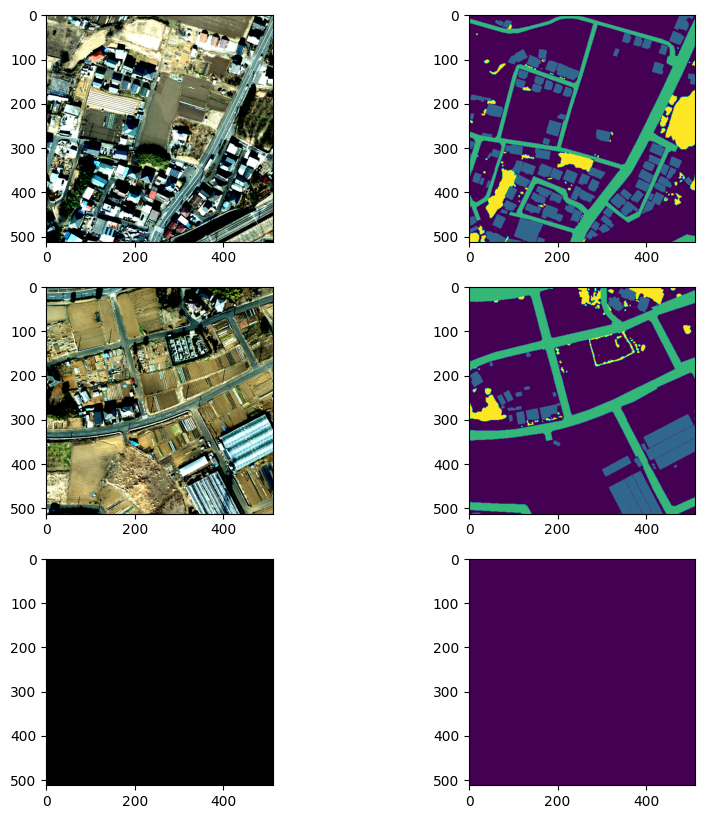

In [ ]:
for i,(img,mask) in enumerate(train_loader):
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    img1 = np.clip(img1, 0, 1)
    img2 = np.clip(img2, 0, 1)
    img3 = np.clip(img3, 0, 1)
    fig , ax =  plt.subplots(3, 2, figsize=(10,10))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [ ]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)

In [ ]:
class unet_model(nn.Module):
    def __init__(self,out_channels=5,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [ ]:
model = unet_model().to(device)

In [ ]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [ ]:

def train(model, train_loader, criterion, optimizer, scaler):
    model.train()
    loop = tqdm(enumerate(train_loader),total=len(train_loader))
    for batch_idx, (image, mask) in loop:
        image = image.to(device)
        mask = mask.to(device)
        mask = mask.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(image)
            loss = criterion(predictions, mask)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    return loss.item()

In [ ]:
from sklearn.metrics import confusion_matrix

def compute_IoU(cm):
    sum_over_row = cm.sum(axis=0)
    sum_over_col = cm.sum(axis=1)
    intersection = np.diag(cm)

    union = sum_over_row + sum_over_col - intersection

    iou = intersection / (union + 1e-8)

    return  np.nanmean(iou)

def compute_Dice(cm):
    sum_over_row = cm.sum(axis=0)
    sum_over_col = cm.sum(axis=1)
    true_positives = np.diag(cm)

    dice = (2 * true_positives) / (sum_over_row + sum_over_col + 1e-8)

    return  np.nanmean(dice)

In [ ]:

def inference(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()
    labels = np.arange(5)
    cm = np.zeros((5,5))
    with torch.no_grad():
        for i,(image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(image)),axis=1)
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            for j in range(len(mask)):
                true = mask[j].cpu().detach().numpy().flatten()
                pred = preds[j].cpu().detach().numpy().flatten()
                cm += confusion_matrix(true, pred, labels=labels)
        dice_score = compute_Dice(cm)
        iou_score = compute_IoU(cm)
        for i in range(1):
            image = image.squeeze(0)
            mask = mask.squeeze(0)
            img1 = np.transpose(np.array(image.to('cpu')),(1,2,0))
            preds1 = np.array(preds.squeeze(0).to('cpu'))
            mask1 = np.array(mask.to('cpu'))
            img1 = np.clip(img1, 0, 1)
            plt.subplot(1,3, 1)
            plt.imshow(img1)
            plt.title('image')
            plt.axis('off')
            plt.subplot(1,3, 2)
            plt.imshow(mask1)
            plt.title('mask')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(preds1)
            plt.title('Prediction')
            plt.axis('off')
            plt.show()
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score}")
    print(f"IoU score: {iou_score}")
    return dice_score,iou_score


100%|██████████| 200/200 [02:49<00:00,  1.18it/s, loss=0.615]


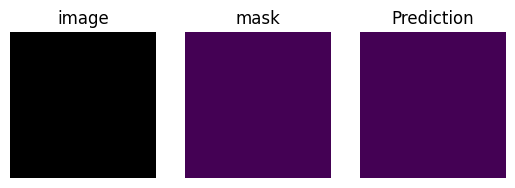

Got 105784328/137625600 with acc 76.86
Dice score: 0.5844291276677884
IoU score: 0.46852665092482904



100%|██████████| 200/200 [02:52<00:00,  1.16it/s, loss=0.576]


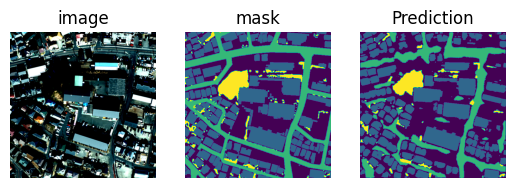

Got 110898153/137625600 with acc 80.58
Dice score: 0.6086704121675853
IoU score: 0.49774242660834106



100%|██████████| 200/200 [02:53<00:00,  1.16it/s, loss=0.358]


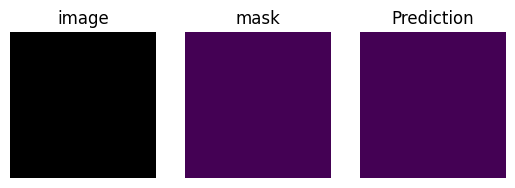

Got 114281471/137625600 with acc 83.04
Dice score: 0.6371475747642142
IoU score: 0.5336006132880848



100%|██████████| 200/200 [02:52<00:00,  1.16it/s, loss=0.301]


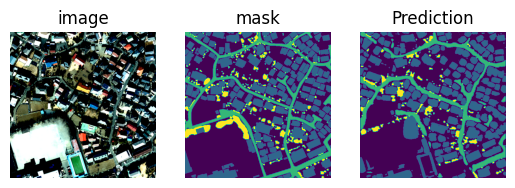

Got 116095616/137625600 with acc 84.36
Dice score: 0.6967183954632566
IoU score: 0.5767027894751232



100%|██████████| 200/200 [02:53<00:00,  1.16it/s, loss=0.23]


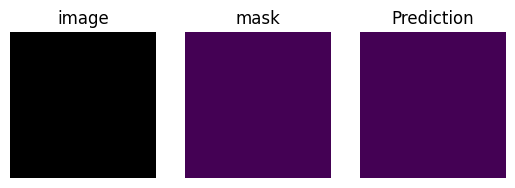

Got 117037339/137625600 with acc 85.04
Dice score: 0.7714478207861781
IoU score: 0.6387709481818866



100%|██████████| 200/200 [02:52<00:00,  1.16it/s, loss=0.327]


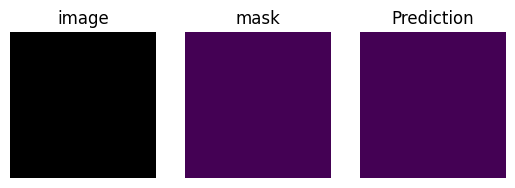

Got 116997266/137625600 with acc 85.01
Dice score: 0.8069539116863261
IoU score: 0.6801397976350245



100%|██████████| 200/200 [02:52<00:00,  1.16it/s, loss=0.263]


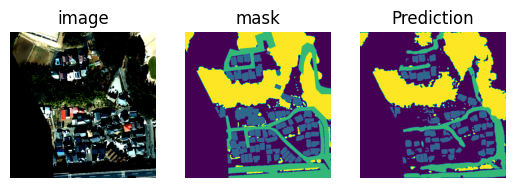

Got 112812639/137625600 with acc 81.97
Dice score: 0.7804628215168481
IoU score: 0.6417577885979376



100%|██████████| 200/200 [02:52<00:00,  1.16it/s, loss=0.318]


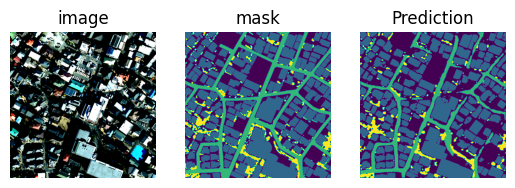

Got 118565697/137625600 with acc 86.15
Dice score: 0.8222998561988675
IoU score: 0.7014508826082865



100%|██████████| 200/200 [02:52<00:00,  1.16it/s, loss=0.365]


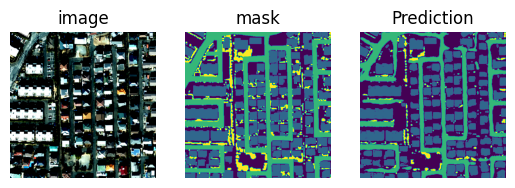

Got 118310087/137625600 with acc 85.97
Dice score: 0.8082245295358412
IoU score: 0.684398935686135



100%|██████████| 200/200 [02:52<00:00,  1.16it/s, loss=0.242]


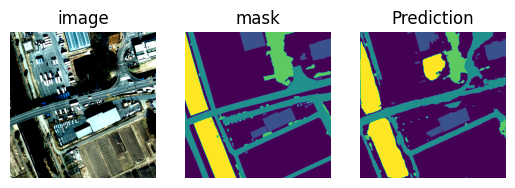

Got 120551501/137625600 with acc 87.59
Dice score: 0.8387313982309734
IoU score: 0.7254731565872945



100%|██████████| 200/200 [02:53<00:00,  1.15it/s, loss=0.22]


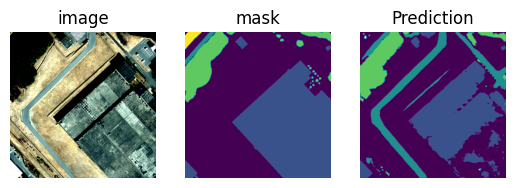

Got 120389230/137625600 with acc 87.48
Dice score: 0.8369410740170654
IoU score: 0.7232121848455575



100%|██████████| 200/200 [02:53<00:00,  1.15it/s, loss=0.202]


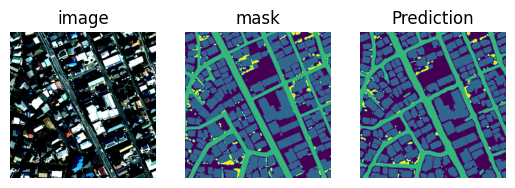

Got 121127687/137625600 with acc 88.01
Dice score: 0.8499580741984267
IoU score: 0.741665141995169



100%|██████████| 200/200 [02:53<00:00,  1.16it/s, loss=0.184]


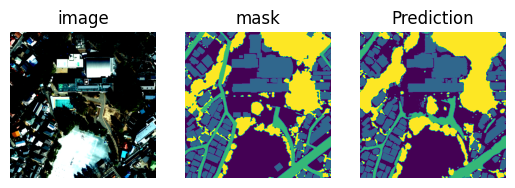

Got 120614283/137625600 with acc 87.64
Dice score: 0.8194955114266342
IoU score: 0.7014888078904079



100%|██████████| 200/200 [02:53<00:00,  1.15it/s, loss=0.225]


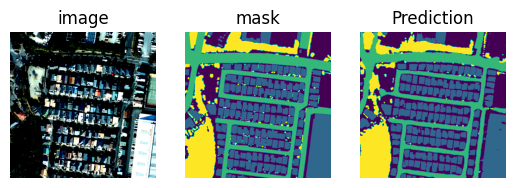

Got 118744517/137625600 with acc 86.28
Dice score: 0.793871227495617
IoU score: 0.6678825465593354



100%|██████████| 200/200 [02:53<00:00,  1.15it/s, loss=0.215]


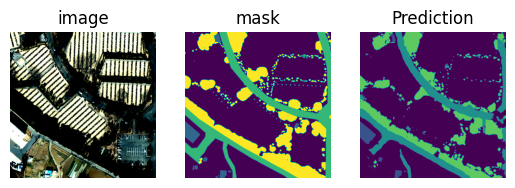

Got 121165258/137625600 with acc 88.04
Dice score: 0.8420606957903457
IoU score: 0.7310812189902428



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.261]


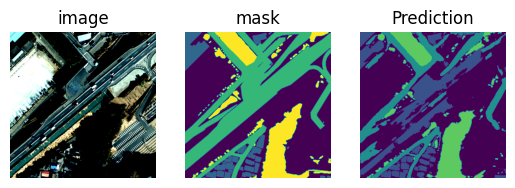

Got 121008278/137625600 with acc 87.93
Dice score: 0.849842985654124
IoU score: 0.7418423139959618



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.225]


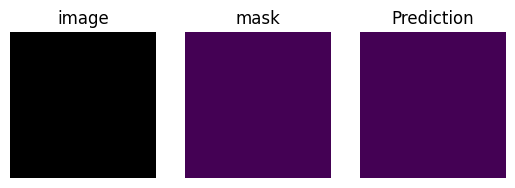

Got 121116405/137625600 with acc 88.00
Dice score: 0.844798659359942
IoU score: 0.7342136078021972



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.229]


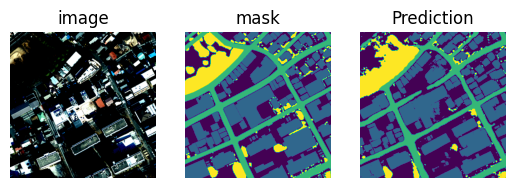

Got 121370421/137625600 with acc 88.19
Dice score: 0.8485423344922122
IoU score: 0.7406772910892779



100%|██████████| 200/200 [02:55<00:00,  1.14it/s, loss=0.211]


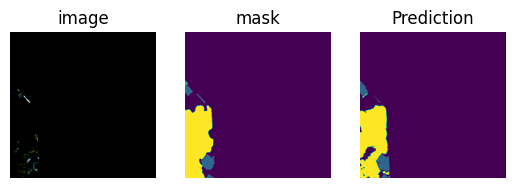

Got 121384856/137625600 with acc 88.20
Dice score: 0.8531428857475651
IoU score: 0.7473720760023431



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.164]


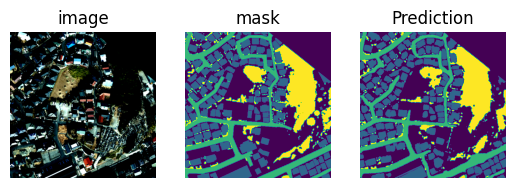

Got 121916998/137625600 with acc 88.59
Dice score: 0.8486493820988615
IoU score: 0.7402645109604545



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.159]


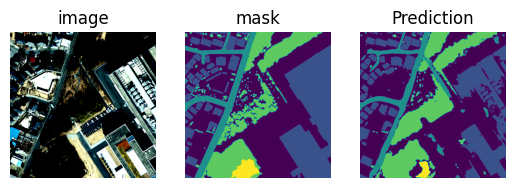

Got 120503035/137625600 with acc 87.56
Dice score: 0.8459597615430645
IoU score: 0.7351672683385078



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.198]


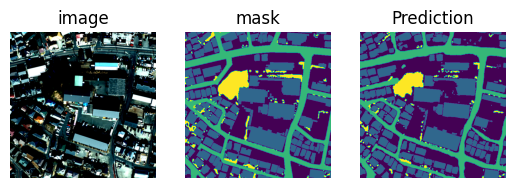

Got 122229750/137625600 with acc 88.81
Dice score: 0.8516986686921244
IoU score: 0.7449254571483216



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.215]


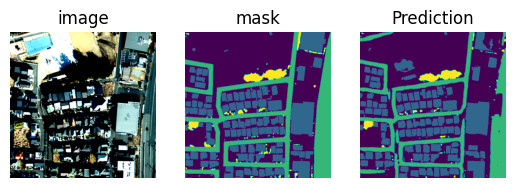

Got 121615365/137625600 with acc 88.37
Dice score: 0.8465860433128938
IoU score: 0.7378912367539849



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.164]


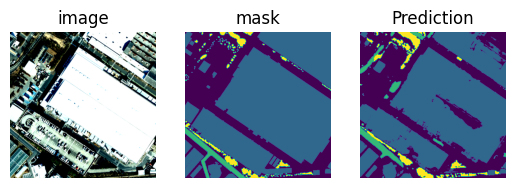

Got 122186665/137625600 with acc 88.78
Dice score: 0.8576962283497602
IoU score: 0.7543050533824756



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.143]


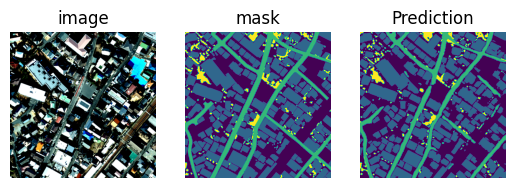

Got 122393038/137625600 with acc 88.93
Dice score: 0.857478212788925
IoU score: 0.753827231193062



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.222]


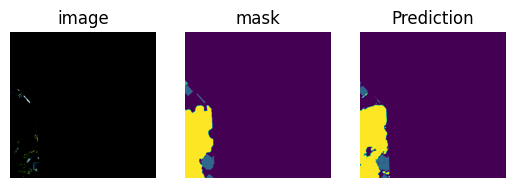

Got 121867913/137625600 with acc 88.55
Dice score: 0.8471543505655623
IoU score: 0.7385286708009425



100%|██████████| 200/200 [02:53<00:00,  1.15it/s, loss=0.149]


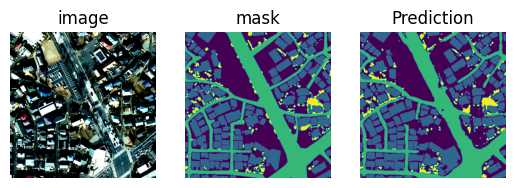

Got 122818443/137625600 with acc 89.24
Dice score: 0.8641616049125205
IoU score: 0.7633673437356034



100%|██████████| 200/200 [02:53<00:00,  1.15it/s, loss=0.175]


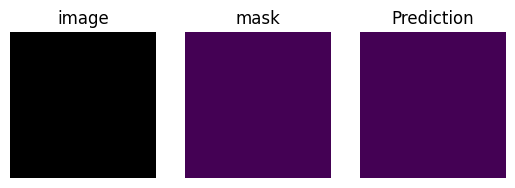

Got 122630255/137625600 with acc 89.10
Dice score: 0.8566188706421517
IoU score: 0.7525405453421733



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.138]


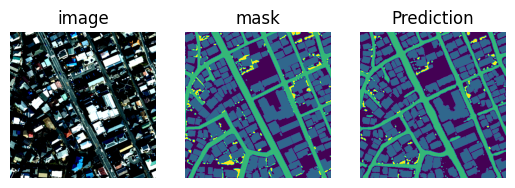

Got 122256413/137625600 with acc 88.83
Dice score: 0.8629389212396263
IoU score: 0.761150134459751



100%|██████████| 200/200 [02:53<00:00,  1.15it/s, loss=0.142]


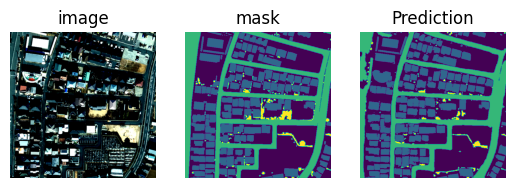

Got 122630131/137625600 with acc 89.10
Dice score: 0.860041120885494
IoU score: 0.7577410290168087



100%|██████████| 200/200 [02:55<00:00,  1.14it/s, loss=0.0967]


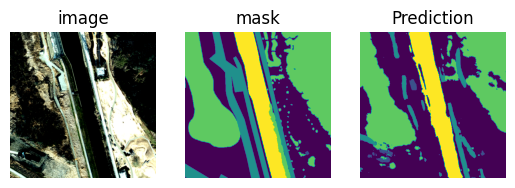

Got 122361318/137625600 with acc 88.91
Dice score: 0.8612305929486892
IoU score: 0.7591568803774429



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.147]


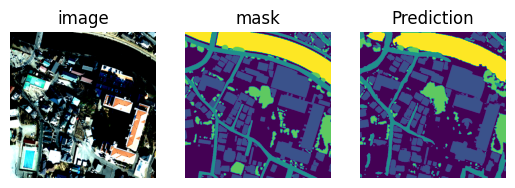

Got 122719423/137625600 with acc 89.17
Dice score: 0.8641507377204128
IoU score: 0.7635192437543104



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.171]


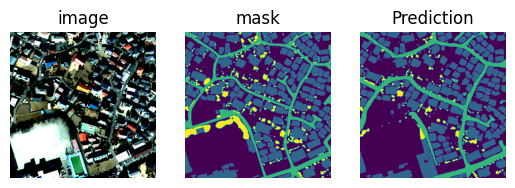

Got 121562267/137625600 with acc 88.33
Dice score: 0.8507677162771756
IoU score: 0.7435607773174167



100%|██████████| 200/200 [02:55<00:00,  1.14it/s, loss=0.127]


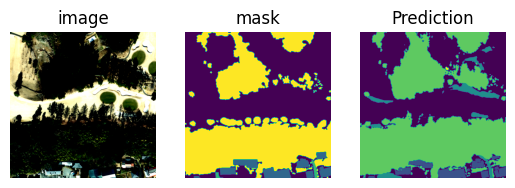

Got 122179825/137625600 with acc 88.78
Dice score: 0.8632239131233114
IoU score: 0.761878831478066



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.062]


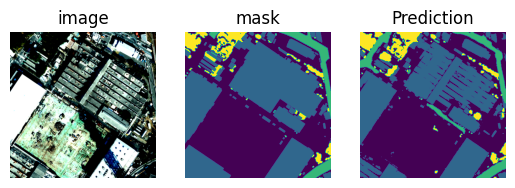

Got 123001825/137625600 with acc 89.37
Dice score: 0.8666814789003882
IoU score: 0.767548636013945



100%|██████████| 200/200 [02:55<00:00,  1.14it/s, loss=0.135]


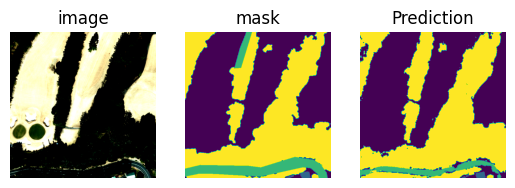

Got 119865733/137625600 with acc 87.10
Dice score: 0.8399179335289718
IoU score: 0.7279049367672641



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.145]


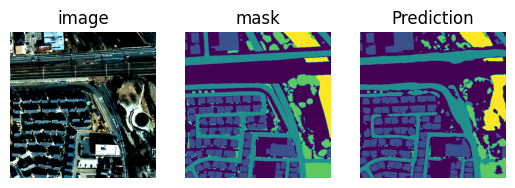

Got 123171903/137625600 with acc 89.50
Dice score: 0.8630730420991076
IoU score: 0.7623255015853168



100%|██████████| 200/200 [02:55<00:00,  1.14it/s, loss=0.178]


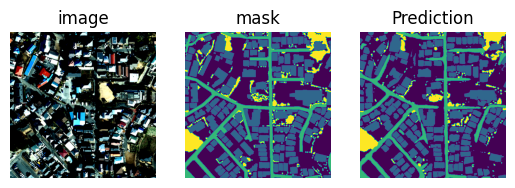

Got 122626140/137625600 with acc 89.10
Dice score: 0.8449861015632825
IoU score: 0.7362253540412433



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.135]


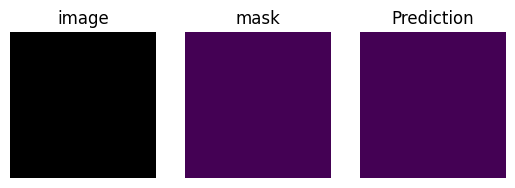

Got 123210877/137625600 with acc 89.53
Dice score: 0.8663244056105845
IoU score: 0.7669927641363371



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.0762]


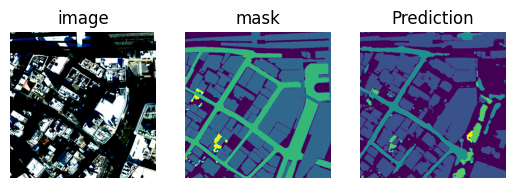

Got 123236342/137625600 with acc 89.54
Dice score: 0.8696108480718892
IoU score: 0.7718303573565357



100%|██████████| 200/200 [02:55<00:00,  1.14it/s, loss=0.0947]


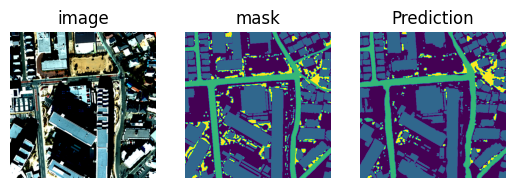

Got 122798149/137625600 with acc 89.23
Dice score: 0.8599168080125086
IoU score: 0.757100937145102



100%|██████████| 200/200 [02:55<00:00,  1.14it/s, loss=0.116]


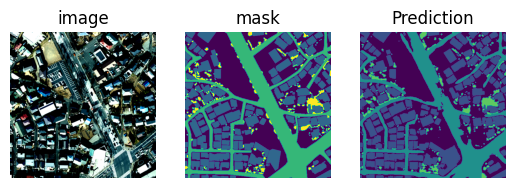

Got 123379414/137625600 with acc 89.65
Dice score: 0.870516298588217
IoU score: 0.7733940322085908



100%|██████████| 200/200 [02:54<00:00,  1.14it/s, loss=0.123]


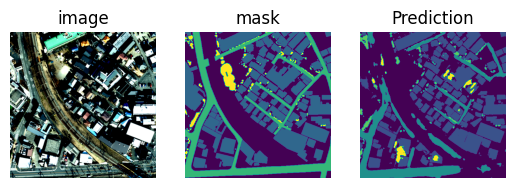

Got 121533784/137625600 with acc 88.31
Dice score: 0.8137836866573886
IoU score: 0.6970777873123841



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.0796]


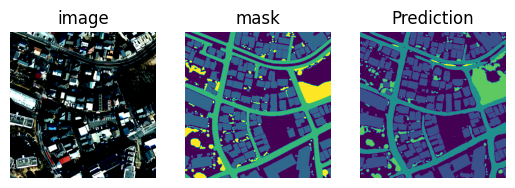

Got 122984256/137625600 with acc 89.36
Dice score: 0.8687516639293676
IoU score: 0.7709032009002308



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.104]


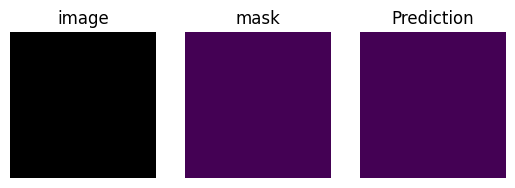

Got 123296623/137625600 with acc 89.59
Dice score: 0.8704360033106646
IoU score: 0.7733621520501381



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.118]


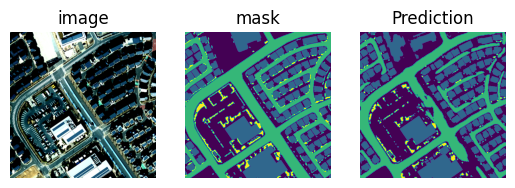

Got 122785094/137625600 with acc 89.22
Dice score: 0.86481144719514
IoU score: 0.76507508393139



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.151]


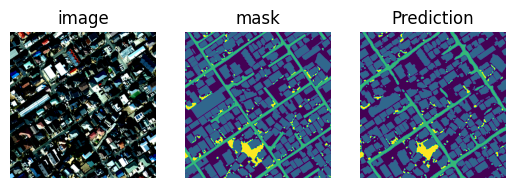

Got 122489295/137625600 with acc 89.00
Dice score: 0.8633974192281817
IoU score: 0.7628227774180878



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.129]


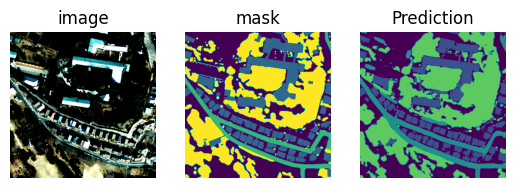

Got 122576491/137625600 with acc 89.07
Dice score: 0.8615532817784415
IoU score: 0.759957819746248



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.101]


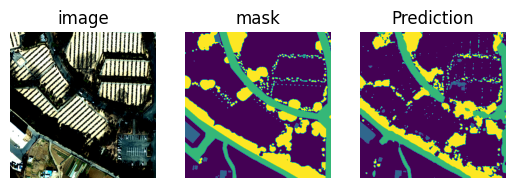

Got 123036968/137625600 with acc 89.40
Dice score: 0.8682106682472425
IoU score: 0.7699749040789436



100%|██████████| 200/200 [02:54<00:00,  1.15it/s, loss=0.149]


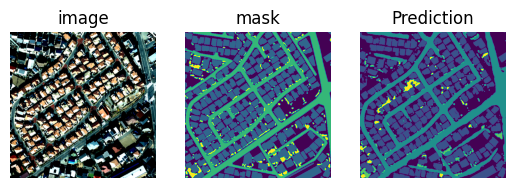

Got 115042275/137625600 with acc 83.59
Dice score: 0.6991384018791804
IoU score: 0.5886576135565696



In [ ]:
epochs = 50
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
loss_val =[]
dice_val = []
IoU_val = []
scaler = torch.cuda.amp.GradScaler()
for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer,scaler)
    loss_val.append(loss)
    dice,IoU = inference(val_loader,model)
    dice_val.append(dice)
    IoU_val.append(IoU)
    print()

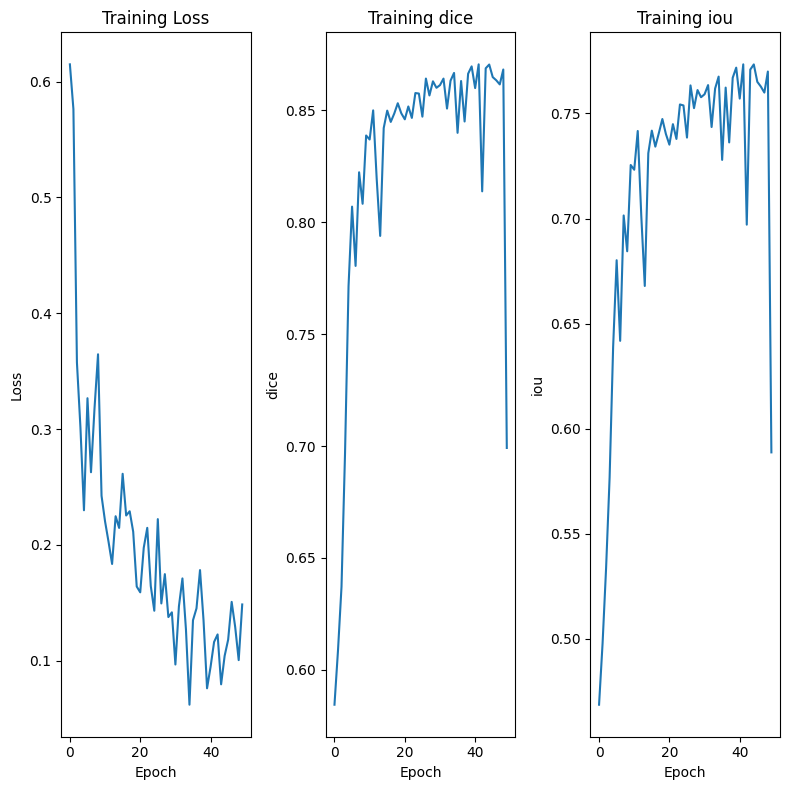

In [ ]:
epochs = range(50)
plt.figure(figsize=(8, 8))
plt.subplot(1,3,1)
plt.plot(epochs,loss_val)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.subplot(1,3,2)
plt.plot(epochs,dice_val)
plt.xlabel('Epoch')
plt.ylabel('dice')
plt.title('Training dice')
plt.subplot(1,3,3)
plt.plot(epochs,IoU_val)
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.title('Training iou')
plt.tight_layout()
plt.show()

In [ ]:
num_correct = 0
num_pixels = 0
dice_score = 0
iou_score = 0
labels = np.arange(5)
cm = np.zeros((5,5))
model.eval()

with torch.no_grad():
    for image, mask in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        softmax = nn.Softmax(dim=1)
        preds = torch.argmax(softmax(model(image)),axis=1)
        num_correct += (preds == mask).sum()
        num_pixels += torch.numel(preds)
        for j in range(len(mask)):
              true = mask[j].cpu().detach().numpy().flatten()
              pred = preds[j].cpu().detach().numpy().flatten()
              cm += confusion_matrix(true, pred, labels=labels)
        image = image.squeeze(0)
        mask = mask.squeeze(0)
        img1 = np.transpose(np.array(image.to('cpu')),(1,2,0))
        preds1 = np.array(preds.squeeze(0).to('cpu'))
        mask1 = np.array(mask.to('cpu'))
        img1 = np.clip(img1, 0, 1)
        plt.subplot(1,3, 1)
        plt.imshow(img1)
        plt.title('image')
        plt.axis('off')
        plt.subplot(1,3, 2)
        plt.imshow(mask1)
        plt.title('mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(preds1)
        plt.title('Prediction')
        plt.axis('off')
        plt.show()
    dice_score = compute_Dice(cm)
    iou_score = compute_IoU(cm)
print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
print(f"Dice score: {dice_score}")
print(f"IoU score: {iou_score}")

